# Initialisation and Data Read

### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Initialisation and Inputs

In [22]:
# Define a set of inputs
Tin = 120
Ain = 0
Aout = 1

In [23]:
# Identify filepaths to each set of Einstein coefficients
file_paths = ['FredFiles/MIES_QUANT.txt', 
              'FredFiles/LG_QUANT.txt']

In [24]:
#PHYSICAL CONSTANTS
h = 6.62607015e-34  # Planck constant in J·s
c = 2.99792458e8  # Speed of light in m/s
k = 1.380649e-23  # Boltzmann constant in J/K

#TRANSITION CONSTANTS
Partition = 6.30163002356721E+0000  # From Values.txt in Synthetic OH

#VIBROTATIONAL CONSTANTS FOR v = 6
Y = -9.795  
D = 0.0018
B = 14.349

### Extraction of Useful Data from Fredware

In [25]:
def read_fredquantfile(file_path):
#The data is extracted from a Fred file, this module reads in 
#the neccessary info. The original Fred file is MIES_QUANT.INC
#To make it readable I converted it to a text file, removed everything 
#but the OH(6-2)* transition and put a // in front of any non OH lines.

    with open(file_path, "r") as file:
        data = file.readlines()

    # Initialize lists to store extracted information
    wavelengths = []
    j2_values = []
    a_values = []
    symbols = []

    # Iterate through each line and extract required information
    for line in data:
    
        if line.startswith("//"): #ignore // lines
            continue
        
        if line.startswith("  "):
            continue
        
        if 'v2' not in line:
            continue
            
        wavelength = int(line.split()[0].strip(':'))
        j2_value = float(line.split('J2:=')[1].split(';')[0].strip())
        a_value = float(line.split('A:=')[1].split(';')[0].strip())
        symbol = line.split("symbol:='")[1].split("';")[0].strip()
    
        wavelengths.append(wavelength)
        j2_values.append(j2_value)
        a_values.append(a_value)
        symbols.append(symbol)

    quant = pd.DataFrame({
        "Symbol": symbols,
        "Wavelength": wavelengths,
        "Jprime": j2_values,
        "A": a_values
    })
    
    return quant

In [26]:
def get_fprime(quant, B, D, Y):
    
    Fprime = []
    Jprime = quant["Jprime"]
    
    for i in range(len(quant)):
            
        if int(quant["Symbol"][i][1]) == 1:
            F_value = 100 * (B*((Jprime[i] + .5)**2 -1 - (.5 * np.sqrt(4*(Jprime[i] + .5)**2 + Y*(Y - 4)))) - D*(Jprime[i]**4))
            Fprime.append(F_value)
            
        elif int(quant["Symbol"][i][1]) == 2:
            F_value = 100 * (B*((Jprime[i] + .5)**2 -1 + (.5 * np.sqrt(4*(Jprime[i] + .5)**2 + Y*(Y - 4)))) - D*(Jprime[i]**4))
            Fprime.append(F_value)
    
    return Fprime

In [27]:
#Read the rest of the quantum parameters from the specified files above
quant = read_fredquantfile(file_paths[Ain])
new_quant = read_fredquantfile(file_paths[Aout])

#Make sure the column naming makes sense
quant.rename(columns={'A': 'Ain'}, inplace=True)
quant['Aout'] = new_quant['A']

Fprimes = get_fprime(quant, B, D, Y)
print(Fprimes)
Fprime = pd.DataFrame (Fprimes, columns = ['Fprime'])


#Create a new dataframe 'parameters' which stores all the necessary data for the calculation
#The line symbol, Fprime, Wavelength, J', and the old and new Einstein coefficients
parameters = pd.merge(Fprime, quant, left_index=True, right_index=True)
print(parameters)

[8462.3115, -4515.945960022041, 13123.523460022043, 2086.9457688893453, 20857.391731110656, 11372.50848158938, 31620.46901841062, 23362.633421346214, 45364.94407865379, 38070.39076415089, 55498.62426377961]
          Fprime Symbol  Wavelength  Jprime    Ain   Aout
0    8462.311500  P2(2)        8382     0.5  0.841  0.682
1   -4515.945960  P1(2)        8399     1.5  0.529  0.434
2   13123.523460  P2(3)        8415     1.5  0.779  0.641
3    2086.945769  P1(3)        8430     2.5  0.644  0.534
4   20857.391731  P2(4)        8452     2.5  0.762  0.636
5   11372.508482  P1(4)        8465     3.5  0.690  0.579
6   31620.469018  P2(5)        8493     3.5  0.760  0.641
7   23362.633421  P1(5)        8505     4.5  0.717  0.608
8   45364.944079  P2(6)        8539     4.5  0.764  0.651
9   38070.390764  P1(6)        8548     5.5  0.736  0.629
10  55498.624264  P1(7)        8597     6.5  0.751  0.647


# Conversion calculation

## Calculate the line equation to be plotted x and y values as per formulae below

In [28]:
x = []
y = []
for i in range(len(parameters)):
    x.append(parameters['Fprime'][i])
    y.append(( (-h*c)/(k*Tin) )*x[i] + Partition)

Text(0, 0.5, '$\\ln \\left( \\frac{I}{{A_{{in}} \\cdot (2(2J^\\prime + 1))}} \\right)$')

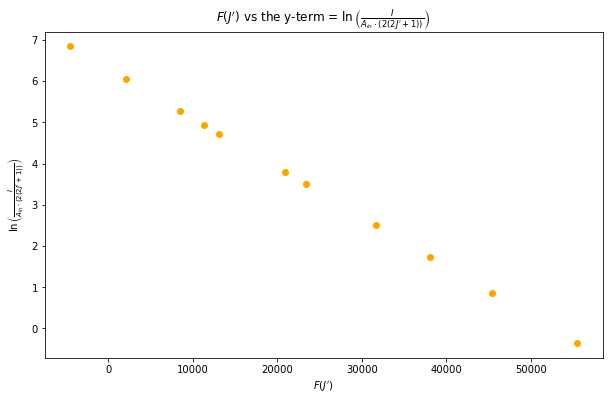

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='orange')
plt.title(r'$F(J^\prime)$ vs the y-term = $\ln \left( \frac{I}{{A_{{in}} \cdot (2(2J^\prime + 1))}} \right)$')
plt.xlabel(r'$F(J^\prime)$')
plt.ylabel(r'$\ln \left( \frac{I}{{A_{{in}} \cdot (2(2J^\prime + 1))}} \right)$')

## Add correction term

In [30]:
y_new = []
for i in range(len(parameters)):
    Y = y[i] + np.log(parameters['Ain'][i] / parameters['Aout'][i]) # Add correction term
    y_new.append(Y)

## Use line fitting to extract the gradient

In [31]:
# Using polyfit

grad_poly, inter_poly = np.polyfit( x, y_new, 1)
print(grad_poly, inter_poly)

fitline = []
for i in range(len(x)):
    line = grad_poly*x[i] + inter_poly
    fitline.append(line)

-0.00012077941216080253 6.498314532750794


In [32]:
# Expected trendline
expected = []
for i in range(len(x)):
    expected_m = grad_poly
    expected.append(expected_m * x[i] + inter_poly)

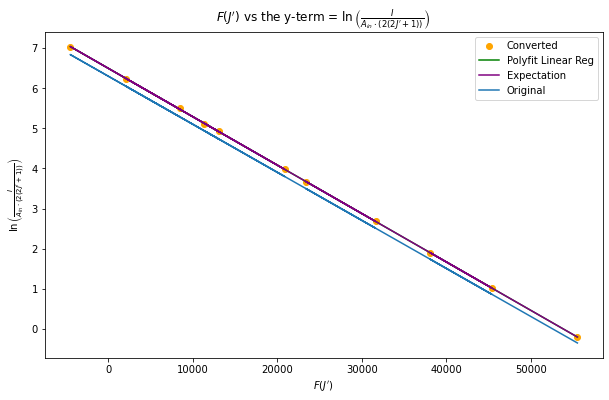

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(x, y_new, color='orange', label='Converted')
plt.plot(x, fitline, color='green', label = 'Polyfit Linear Reg')
plt.plot(x, expected, color='purple', label = 'Expectation')
plt.plot(x,y, label='Original')
plt.title(r'$F(J^\prime)$ vs the y-term = $\ln \left( \frac{I}{{A_{{in}} \cdot (2(2J^\prime + 1))}} \right)$')
plt.xlabel(r'$F(J^\prime)$')
plt.ylabel(r'$\ln \left( \frac{I}{{A_{{in}} \cdot (2(2J^\prime + 1))}} \right)$')
plt.legend()

## Calculate the temperature from the line gradient

In [34]:
Tout = (-h * c) / (k * grad_poly)
print(Tout)

119.12434841033867
